In [2]:
# import load
import pickle
import h5py
import numpy as np
# import theano
# import theano.tensor as T
import math
import chess, chess.pgn
import heapq
import time
import re
import string
import numpy
# import sunfish
import pickle
import random
# import traceback
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet import conv2d
from theano.tensor.signal.pool import pool_2d as max_pool_2d
# import string
# print(string.__file__)
# %run ./sunfish-master/test benchmark
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# import data:
ff = h5py.File("chess_reformatted_full.hdf5","r")
x_train = ff['train']
# ff.close
print x_train.shape

filename = 'chess_labels_reformat'
f = h5py.File(filename+".hdf5", "r")
# turns = f['train_turns']
Y_train = f['train_labels']
# print X_train.shape
# print Y_train[:,0]
# print X_train[:,:,:,0]
# f.close()

print Y_train[0], x_train[0]

(5000000, 8, 48)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [-1  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  1  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
   0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [36]:
xxt = np.zeros(x_train.shape,dtype=np.int8)
xxt[:] = x_train[:]

In [52]:
n=6
print xxt[n,:,:8]
print np.where(Y_train[n,:]==1)

[[ 0  0  0  0  0  0  0  0]
 [-1  0 -1  0  0  0 -1  0]
 [ 0 -1  0  0  0 -1  0 -1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  1  0]
 [ 0  0  1  0  0  1  0  1]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
(array([ 76, 125], dtype=int64),)


In [4]:
# create the network:
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape): # initialize the random weights with argument shape
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def rectify(X): # return max(value, 0)
    return T.maximum(X, 0.)

def softmax(X):
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

def dropout(X, p=0.):
    if p > 0:
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def model(X, w, w2, w3, w4, w5, p_drop_conv, p_drop_hidden):
    # layer 1
    l1a = rectify(conv2d(X, w, border_mode='full'))
    l1 = max_pool_2d(l1a, (2, 2))
    l1 = dropout(l1, p_drop_conv)
    # layer 2
    l2a = rectify(conv2d(l1, w2, ignore_border=True))
    l2 = max_pool_2d(l2a, (2, 2))
    l2 = dropout(l2, p_drop_conv)
    # layer 3
    l3a = rectify(conv2d(l2, w3, ignore_border=True))
    l3b = max_pool_2d(l3a, (2, 2))
    l3 = T.flatten(l3b, outdim=2)
    l3 = dropout(l3, p_drop_conv)
    # layer 4
    l4 = rectify(T.dot(l3, w4))
    l4 = dropout(l4, p_drop_hidden)
    # layer 5
    l5 = rectify(T.dot(l4, w5))
    l5 = dropout(l5, p_drop_hidden)
    # classify the output
    pyx = softmax(T.dot(l5, w_o))
    return l1, l2, l3, l4, l5, pyx

In [5]:
print x_train[0].shape
print x_train[0][0]

(8L, 48L)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [40]:
plt.pcolor(xxt[0,:,:,:8],cmap = plt.cm.gray_r)

IndexError: too many indices for array

In [11]:
# define symbolic Theano variables
X = T.ftensor4()
Y = T.fmatrix()

# x_train = x_train.reshape(-1, 1, 8, 48)
# Y_train = teX.reshape(-1, 1, 28, 28)

X = T.cast(X, 'float64')

# create initial weights
# w = init_weights((6, 8, 8, 128))
# w2 = init_weights((90, 64, 3, 3))
# w3 = init_weights((128, 90, 3, 3))
# w4 = init_weights((128 * 3 * 3, 625))
# w_o = init_weights((625, 128))
# w = init_weights((32, 1, 2, 2))
# w2 = init_weights((64, 32, 2, 2))
# w3 = init_weights((128, 64, 2, 2))
# the input here is the output at the end of w3, of 'faux piels' or 'activated regions' after pooling
# Generates output of shape: input shape + filter shape - 1
# crom conv2d?: 'full' results in shape + filter - 1: or 51 (i think? its not square so idk)
# x dimension: ((48+4-1)/2-4+1)/2-4+1
# divide by 2 for max pooling
# y dimension: 
# w4 = init_weights((128 * 6 * 1, 625))
# w5 = init_weights((625, 625))
# w_o = init_weights((625, 128))


l1, l2, l3, l4, l5, py_x = model(X, w, w2, w3, w4, w5, 0.2, 0.5)
cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
params = [w, w2, w3, w4, w5, w_o]
updates = RMSprop(cost, params, lr=0.05)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=py_x, allow_input_downcast=True)

c:\users\neal\anaconda3\envs\theano_2.7\lib\site-packages\ipykernel_launcher.py:39: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use cuDNN. When using ignore_border=False and not using cuDNN, the only GPU combination supported is when `ws == stride and pad == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.
c:\users\neal\anaconda3\envs\theano_2.7\lib\site-packages\ipykernel_launcher.py:42: UserWarning: ['ignore_border'] are now deprecated in `tensor.nnet.abstract_conv.conv2d` interface and will be ignored.
c:\users\neal\anaconda3\envs\theano_2.7\lib\site-packages\ipykernel_launcher.py:43: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano ver

In [160]:
# calculating the dimensions:
# x dimension (initially 48)
n=2
print np.ceil((np.ceil((np.ceil((48+n-1)/2)-n+1)/2)-n+1)/2) # = 25
# print np.ceil((25-n+1)/2) # 11
# print np.ceil((11-n+1)/2)
# y dimension:
print np.ceil((np.ceil((np.ceil((8+n-1)/2)-n+1)/2)-n+1)/2)

6.0
1.0


In [12]:
##### training loop:
# sweet, retarts totally work
x_test = x_train[:100,:,:].reshape(-1,1,8,48)
n = 512
for i in range(200):
    print i
    for j in range(0,len(x_train),len(x_train)/10):
        xx_train = x_train[j:j+len(x_train)/10,:,:].reshape(-1,1,8,48)
        for start, end in zip(range(0, len(xx_train), n), range(n, len(xx_train), n)):
            xx = xx_train[start:end,:,:,:]
    #         xx = xx.reshape(-1,1,8,48)
            yy = Y_train[start:end,:]
    #         print xx.shape, yy.shape
            score = train(xx, yy)
#             print cost
    #     print predict(x[:,:,:,:100])
        print score
#         print np.mean(Y_train[:100,:] - predict(x_test[:100,:,:,:]))

0


KeyboardInterrupt: 

In [22]:
# print x_test[0,:,:,:]
print Y_train[0,:], predict([x_test[0,:,:,:]])
pp = np.where(Y_train[0,:]==1)[0]
print predict([x_test[0,:,:,:]])[0][18],predict([x_test[0,:,:,:]])[0][114],

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [[ 0.00776554  0.00882496  0.01176882  0.01096533  0.00809762  0.00808268
   0.00597819  0.00363807  0.00547274  0.00709316  0.0060447   0.00896929
   0.01115703  0.00598241  0.00329646  0.00420165  0.00420723  0.00647068
   0.00793373  0.00854914  0.00556656  0.00383905  0.00388323  0.00290295
   0.00507902  0.00637444  0.00593218  0.00779121  0.00645699  0.00612732
   0.00524619  0.00348796  0.00371522  0.00444536  0.00834259  0.00938208
   0.00768624  0.00665224  0.00454393  0.0042025   0.00440465  0.00468784
   0.01055602  0.00890718  0.00835118  0.01128011  0.0044364   0.00369037
   0.00498345  0.00611439  0.00917647  0.01131953  0.01129085  0.00782107
   0.00922112  0.00691674  0.00715365  0.01230655  0.01379201  0.01549391

In [24]:
print x_test[0,0,:,:]

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [-1  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  1  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
   0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0 

ValueError: need more than 1 value to unpack

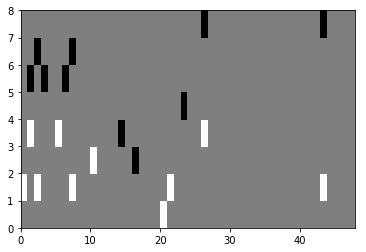

In [27]:
plt.pcolor(x_test[0,0,:,:],cmap = plt.cm.gray_r)
# plt.pcolor(Y_train[0,:],cmap = plt.cm.gray_r)

In [33]:
print x_test[0,:,:,:8]
print x_test[0,:,:,8:16]
print x_test[0,:,:,16:24]
print x_test[0,:,:,24:32]
print x_test[0,:,:32:40]
print Y_train[0,:].reshape(16,8)

[[[ 0  0  0  0  0  0  0  0]
  [-1  0 -1  0  0  0  0 -1]
  [ 0  0  0  0  0  0  0  0]
  [ 0 -1  0  0  0 -1  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  1  0  1  0  0  1  0]
  [ 0  0  1  0  0  0  0  1]
  [ 0  0  0  0  0  0  0  0]]]
[[[ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0 -1  0  0  0  0  0]
  [ 0  0  0  0  0  0  1  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]]
[[[ 0  0  0  0 -1  0  0  0]
  [ 0  0  0  0  0 -1  0  0]
  [ 1  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  1]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]]
[[[ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0 -1  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  1  0  0  0  0  0]]]
[[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0
    0  0  0  0  0  0 